# SmartSim 101
In this notebook you will set up a SmartSim experiment consisting of an `Orchestrator` (a wrapper around Redis DB) and one simulation. The simulation is [John Burkardt's webpe](https://people.sc.fsu.edu/~jburkardt/) Finite-Difference solution of the time-independent heat equation (see the `README.md` file of this repo for more details).

## Some important references

Both SmartSim and SmartRedis have online documentation, combined into one single website. As they are actively developed, you will need to pick the correct version of the docs.

- if you `pip install`ed SmartSim (and the SmartRedis Python client), then you will want to look into [this version of the documentation](https://www.craylabs.org/docs/overview.html).
- if you built from source, then you will need [this version of the documentation](https://www.craylabs.org/develop/overview.html)

They will be useful especially when you will modify the simulation code, as they contain basic examples which cover all the material of this notebook.

## Setup - some options to set
As first step, we import some libraries which will be useful.

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

Now you can decide what implementation of the simulation you want to instrument. Just set `language` to one out of `cpp` (for C++), `c` (for C), `python`, and `fortran`. Then, depending the system you are running on, you will need to pick a launcher. If you are on `swan`, then pick `pbs`. On other clusters or supercomputers, you might want to pick `slurm`. Finally, if you are running this on your own machine (laptop or desktop), just select `local`. A couple other parameters will be set for you based on these choices.

In [26]:
# Language options: c, cpp, fortran, python
language = "c"

assert language in ["cpp", "python", "c", "fortran"]
lang_to_exe = {"cpp": "src/cpp/build/heat_steady",
               "c": "src/c/build/heat_steady",
               "fortran": "src/fortran/build/heat_steady",
               "python": "python"}
exe = lang_to_exe[language]

# Deployment options: local (laptop), pbs, slurm. (Assuming a Cray XC sytem, otherwise interface will have to be adjusted.
launcher = 'pbs'

assert launcher in ['pbs', 'slurm', 'local']

launcher_to_if = {'pbs': 'ipogif0', 'slurm': 'ipogif0', 'local': 'lo'}

interface = launcher_to_if[launcher]

## Starting the Experiment

SmartSim, the infrastructure library, is used here to launch the
database and the simulation, but in separate processes.

First, the necessary libraries are imported.

The next line is your first task! You should create a SmartSim `Experiment` named `exp`, and as arguments you should set `heated_plate` as name, and `launcher=launcher` (we defined it above).

In SmartSim, the `Experiment` contains all the entities you will launch and monitor. It is the most important class and has methods to create all most used parts of a workflow, such as `Model`s (which represents applications), DB, and so on.

In [15]:
from smartredis import Client
from smartsim import Experiment
# Initialize an Experiment with the local launcher
# This will be the name of the output directory that holds
# the output from our simulation and SmartSim
exp = Experiment("heated_plate", launcher=launcher)

OK, that was easy. Now something slightly more complex: you need to create the in-memory database on port `6780`, setting `interface=interface` (we defined this above too).
Hint: the `Experiment` class has functions for creating the most used entities.
After that, as you can see, the experiment will start the database. Wait for the cell to be executed and, if all went according to plan, you will see the address where the DB was started!

In [16]:
# create an Orchestrator database reference, 
# generate its output directory, and launch it locally
db = exp.create_database(port=6780, interface=interface)
exp.generate(db, overwrite=True)
exp.start(db)
print(f"Database started at address: {db.get_address()}")

17:42:16 swan SmartSim[11274] INFO Working in previously created experiment
Database started at address: ['10.128.0.21:6780']


## Running an Ensemble of Simulations

To run the simulation, `Experiment.create_run_settings` is used to define how the simulation should be executed. In our case, there is a slight difference between running with Python or with other languages, where we compiled the executable. Thus, we already created a list `exe_args` to hold the arguments for the Python case (it is empty otherwise). Python is also the only language for which we need to copy a file (the script) into the working directory... luckily, SmartSim does it for us.

For the first run, you can leave `exe_args` as is. The simulation will run with default arguments. We'll modify this later.

Now we get to the point where we create the `Model` for our simulation. Remember that the `Model` is SmartSim's view of the application. We just use an `Experiment` member function to create the model (should not be hard to guess it...) and we add the `run_settings` we have just created.


In [17]:
# set simulation parameters we can pass as executable arguments
exe_args = ["fd2d_heat_steady.py"] if language == "python" else []
exe_args.extend(["--nx=41", "--ny=21"])
# create "run settings" for the simulation which define how
# the simulation will be executed when passed to Experiment.start()
settings = exp.create_run_settings(exe,
                                   exe_args=exe_args)
model = exp.create_model("fd_simulation", run_settings=settings)

if language=="python":
    model.attach_generator_files(to_copy="src/python/fd2d_heat_steady.py")
exp.generate(model, overwrite=True)

17:42:37 swan SmartSim[11274] INFO Working in previously created experiment


Now let's start the simulation and wait for the results!

In [18]:
exp.start(model, block=True, summary=False)

17:42:42 swan SmartSim[11274] INFO fd_simulation: New
17:42:47 swan SmartSim[11274] INFO fd_simulation: Completed


If everything worked, you will see that a directory named `heated_plate` has been created. That's where all the code is excuted, and output files are stored. You should be able to open the file named `heated_plate/fd_simulation/fd_simulation.out` and look at the output. It should report a mean value for $U$, which is the temperature field.

But the simulation did not store the results on the DB! Why? Because we did not instrument the code to do so! This is the moment you've been waiting for! Open the source code for the language you picked (it will be in `src/<language>`) and look for the keyword `EXERCISE`. You will only need to modify one function.

Hint: here is which file you should modify for each language:
- C: `src/c/fd2d_heat_steady_test.c`
- C++: `src/cpp/fd2d_heat_steady_test.cpp`
- Fortran: `src/fortran/fd2d_heat_steadt_test.F90`
- Python: `src/python/fd2d_heat_steady.py`

If you are on `swan` need some time to work on the code, remember to exit the allocation (CTRL+D)... you will get one later!

Once you get everything into place (and you build the code, if you are using a compiled language!), re-execute the two cells above. If the simulation completes, you are on the right track and the next section will help you check that everything went smoothly! Also, if the simulation fails, check if the database is still running (if you just restarted the notebook, it should).

## Get the data and visualize it!

In the next cell, you will get the data from the DB and visualize it. You will need two things: a SmartRedis `Client`, which you can initialize with the address you get from `db.get_address()[0]`, setting `cluster=False`, and three calls to get the tensors you have uploaded to the DB from the simulation. The visualization code comes from the original Python simulation code written by John Burkardt.

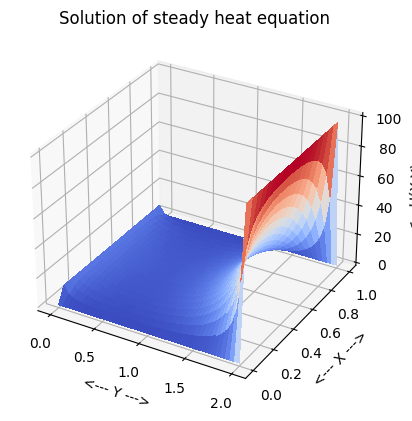

In [19]:
# Connect a SmartRedis client to retrieve data 

client = Client(address=db.get_address()[0], cluster=False)

heat_steady_u = client.get_tensor("steady_state_u")
heat_steady_x = client.get_tensor("steady_state_x")
heat_steady_y = client.get_tensor("steady_state_y")
with plt.ion():
    fig = plt.figure()
    ax = fig.add_subplot ( 111, projection = '3d' )
    ax.plot_surface ( heat_steady_x, heat_steady_y, heat_steady_u, cmap = cm.coolwarm,
    linewidth = 0, antialiased = False )
    ax.set_xlabel ( '<--- Y --->' )
    ax.set_ylabel ( '<--- X --->' )
    ax.set_zlabel ( '<---U(X,Y)--->' )
    ax.set_title ( 'Solution of steady heat equation' )
    plt.draw ( )
    filename = 'fd2d_heat_steady_test01.png'
    fig.savefig ( filename )
    plt.show ( block = False )
    plt.close ( )

As a last check, you can compute the mean value of `heat_steady_u` and compare it to what you find in the simulation output: they should match!

In [20]:
np.mean(heat_steady_u)

15.007022633702533

Congratulations, you've just run your first SmartSim-enhanced simulation! If you want, you can play around with the command line arguments which are available for the simulation... just go to the cell where you start the simulation and add them to `exec_args` like you would add them on the command line (e.g. `--<arg_name>=<arg_value>`)

Now let's do some clean up!

In [21]:
# Optionally clear the database
client.flush_db(db.get_address())

In [22]:
exp.stop(db)

17:42:47 swan SmartSim[11274] INFO Stopping model orchestrator_0 with job name orchestrator_0-CQIOMSAJLZG3


In [23]:
exp.get_status(model)

['Completed']

We can also look at a summary of the executed entities.

In [24]:
exp.summary(format="html")

,Name,Entity-Type,JobID,RunID,Time,Status,Returncode
0,fd_simulation,Model,None,0,9.76854,Completed,0
1,orchestrator_0,DBNode,None,0,30.7994,Cancelled,-9
